diffusion

In [1]:
from fastai.basics import *
from fastai.vision.models.unet import *
from fastai.vision.all import *
from fastai.torch_basics import *
from denoising_diffusion_pytorch import Unet

In [2]:
import wandb
wandb.init(reinit=True)
from fastai.callback.wandb import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marii. Use `wandb login --relogin` to force relogin


In [3]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [4]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        * `n_steps` is $t$
        * `device` is the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model

        # Create $\beta_1, \dots, \beta_T$ linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # $\alpha_t = 1 - \beta_t$
        self.alpha = 1. - self.beta
        # $\bar\alpha_t = \prod_{s=1}^t \alpha_s$
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # $T$
        self.n_steps = n_steps
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        #### Get $q(x_t|x_0)$ distribution
        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # [gather](utils.html) $\alpha_t$ and compute $\sqrt{\bar\alpha_t} x_0$
        mean = gather(self.alpha_bar, t) ** 0.5 * tensor(x0)
        # $(1-\bar\alpha_t) \mathbf{I}$
        var = 1 - gather(self.alpha_bar, t)
        #
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        #### Sample from $q(x_t|x_0)$
        \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}
        """

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        if eps is None:
            eps = torch.randn_like(x0)

        # get $q(x_t|x_0)$
        mean, var = self.q_xt_x0(x0, t)
        # Sample from $q(x_t|x_0)$
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        \begin{align}
        \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \textcolor{lightgreen}{\mu_\theta}(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
        \end{align}
        """

        # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
        
        # NOTEDDDD REMOVED t
        
        eps_theta = self.eps_model(xt,t)
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
        # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
        #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # $\sigma^2$
        var = gather(self.sigma2, t)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

In [5]:
class Q_sample(ItemTransform):
    order=101
    def __init__(self,diffusion):
        self.diffusion=diffusion
    def encodes(self,xy):
        x=xy[0]
        y=xy[-1]
        ts = xy[2][:,0]#torch.randint(0, self.diffusion.n_steps, (x.shape[0],), device=x.device, dtype=torch.long)
        x_type=type(x)
        x=self.diffusion.q_sample(x, x_type(ts), eps=y)
        return (x,*xy[1:-1],y)

In [6]:
class LabelToNoise(ItemTransform):
    order=100
    def encodes(self,xy):
        y=xy[-1]
        return (*xy[:-1],retain_type(torch.randn(y.shape,device=y.device),old=y))

In [7]:
def sample():
    """
    ### Sample images
    """
    with torch.no_grad():
        # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
        x = torch.randn([n_samples, image_channels, 32, 32],
                        device=device)

        # Remove noise for $T$ steps
        for t_ in range(n_steps):
            # $t$
            t = n_steps - t_ - 1
            # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
            x = diffusion.p_sample(x, x.new_full((n_samples,), t, dtype=torch.long))
        return x

In [8]:
n_steps=1000

In [9]:
path = untar_data(URLs.MNIST)
path = untar_data(URLs.CIFAR)

In [10]:
m=Unet(dim=32,channels=3)#UnetTime(img_channels=1,dims=[32, 64, 128, 256, 256],ks=3,stem_stride=2).cuda()

In [11]:
@typedispatch
def show_batch(x:tuple, y:TensorImage, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(samples), max_n), nrows=nrows, ncols=3, figsize=figsize, title='Input/Original/Target')
    ctxs[0::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0),ctxs[0::3],range(max_n))]
    ctxs[0::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(2),ctxs[0::3],range(max_n))]
    ctxs[1::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(1),ctxs[1::3],range(max_n))]
    ctxs[2::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(3),ctxs[2::3],range(max_n))]
    return ctxs

In [12]:
diffusion = DenoiseDiffusion(m,n_steps,torch.device(0))
dls=DataBlock((ImageBlock(cls=PILImageBW),
               ImageBlock(cls=PILImageBW),
               TransformBlock(type_tfms=[DisplayedTransform(enc=lambda o: TensorCategory(o),dec=Category)]),
               ImageBlock(cls=PILImageBW)),
          n_inp=3,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(0.5,1.),LabelToNoise,Q_sample(diffusion)),
          get_items=get_image_files,
          get_x=[lambda x:x,lambda x:x,
                 lambda x: torch.randint(0, n_steps, (1,), dtype=torch.long)],
          splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
).dataloaders(path,bs=128,val_bs=2*128)
dls.show_batch()

IndexError: list index out of range

In [13]:
path.ls()

(#3) [Path('/home/molly/data/cifar10/labels.txt'),Path('/home/molly/data/cifar10/test'),Path('/home/molly/data/cifar10/train')]

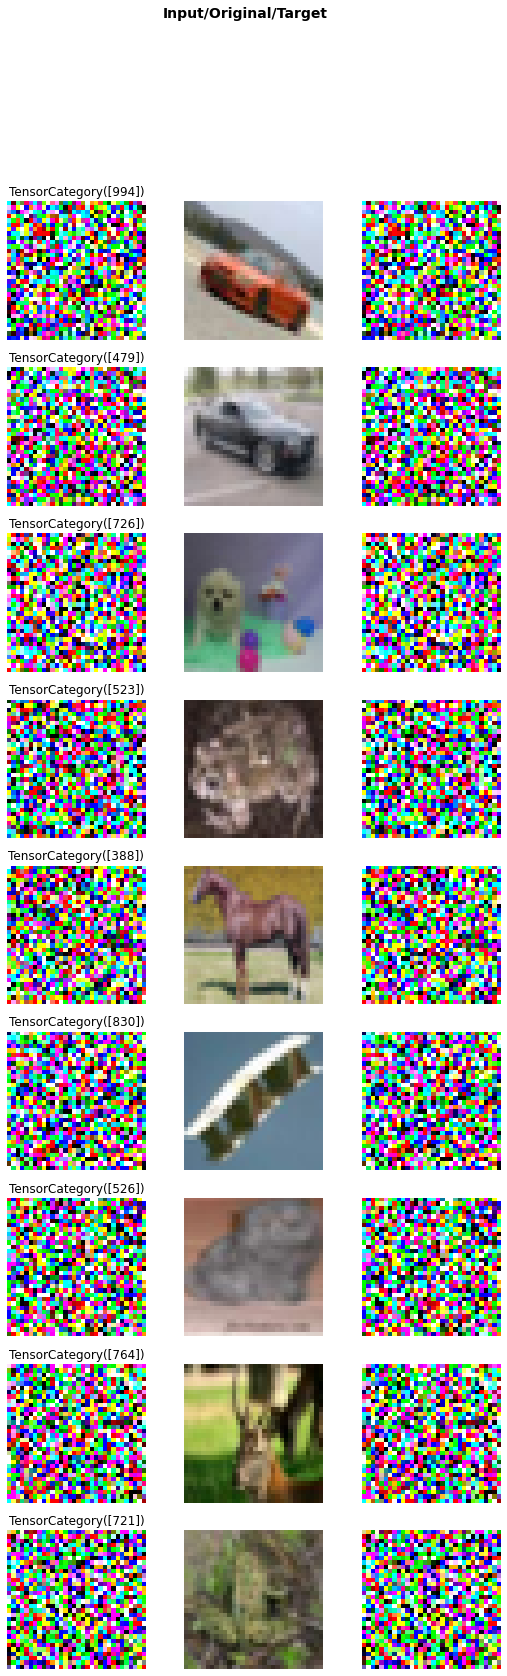

In [14]:
bs=128
diffusion = DenoiseDiffusion(m,n_steps,torch.device(0))
dls=DataBlock((ImageBlock(),
               ImageBlock(),
               TransformBlock(type_tfms=[DisplayedTransform(enc=lambda o: TensorCategory(o),dec=Category)]),
               ImageBlock()),
          n_inp=3,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(0.5,1.),LabelToNoise,Q_sample(diffusion)),
          get_items=get_image_files,
          get_x=[lambda x:x,lambda x:x,
                 lambda x: torch.randint(0, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

In [15]:
class FlattenCallback(Callback):
    def before_batch(self):
        self.learn.xb=(self.xb[0],self.xb[-1].view(self.xb[-1].shape[::2]),)

In [16]:
learn = Learner(dls,m,MSELossFlat(),opt_func=Lamb,cbs=[FlattenCallback,WandbCallback(log_preds_every_epoch=True)])

inp=m.layers[0:0](dls.one_batch()[0])
inp.seq_dict['t']=torch.tensor([5]).cuda()
m.layers[1:4](m.layers[0:1](inp)).shape

In [17]:
learn.fit_flat_cos(6,lr=1e-4,wd=0.)

epoch,train_loss,valid_loss,time
0,0.699252,0.648226,01:58
1,0.375051,0.354264,01:54
2,0.185453,0.168021,01:52
3,0.102715,0.080112,01:53
4,0.064207,0.043586,01:56
5,0.055305,0.053669,01:52


WandbCallback was not able to get prediction samples -> Match length mismatch


In [18]:
@typedispatch
def show_results(x:tuple, y:TensorImage, samples, outs, ctxs=None, max_n=10, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(6*min(len(samples), max_n), ncols=6, figsize=figsize, title='Input/Original/DenoisedImage/Target/Prediction/Diff')
    ctxs[0::6] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0),ctxs[0::6],range(max_n))]
    ctxs[1::6] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(1),ctxs[1::6],range(max_n))]
    ctxs[0::6] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(2),ctxs[0::6],range(max_n))]
    ctxs[2::6] = [(b-o).show(ctx=c, **kwargs) for b,o,c,_ in zip(samples.itemgot(0),outs.itemgot(0),ctxs[2::6],range(max_n))]
    ctxs[3::6] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(3),ctxs[3::6],range(max_n))]
    ctxs[4::6] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(0),ctxs[4::6],range(max_n))]
    ctxs[5::6] = [(b-targ).show(ctx=c, **kwargs) for b,targ,c,_ in zip(outs.itemgot(0),samples.itemgot(3),ctxs[5::6],range(max_n))]
    return ctxs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

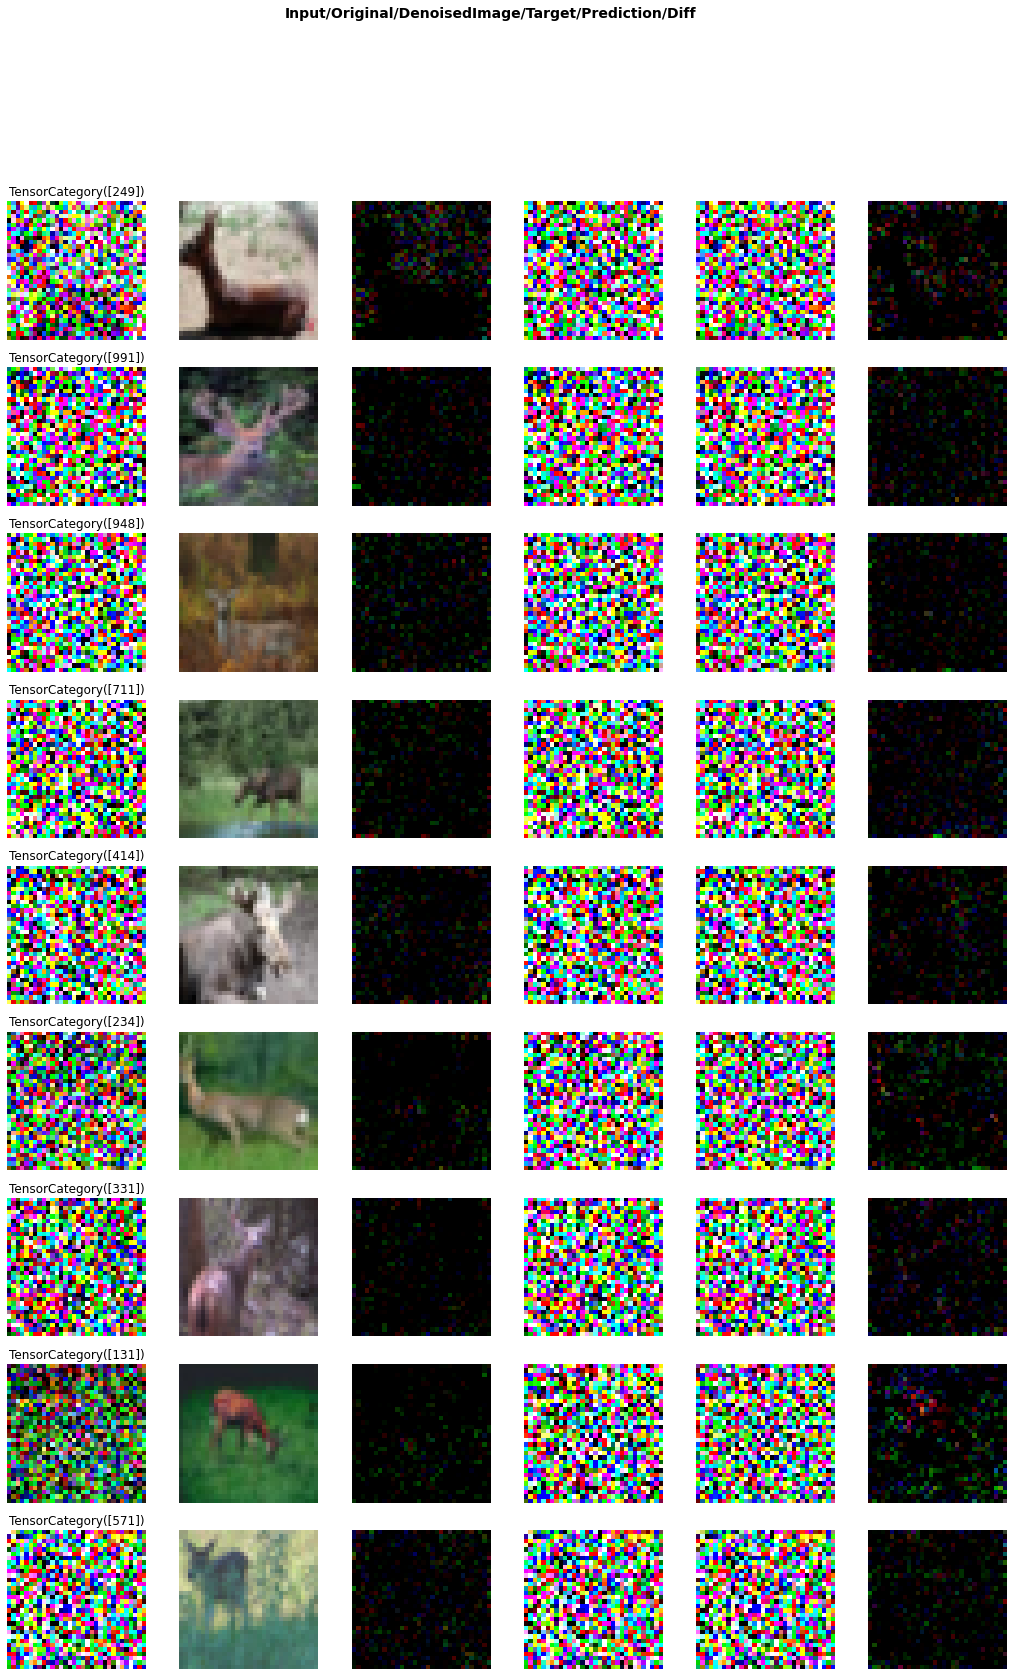

In [19]:
learn.show_results()

In [20]:
n_samples=12
image_channels=3
diffusion = DenoiseDiffusion(m,n_steps,torch.device(0))
device=torch.device(0)
xs = sample()

In [ ]:
show_images((logit((xs.repeat(1,3,1,1)-xs.repeat(1,3,1,1).mean())/xs.repeat(1,3,1,1).std()).sigmoid()),nrows=4)

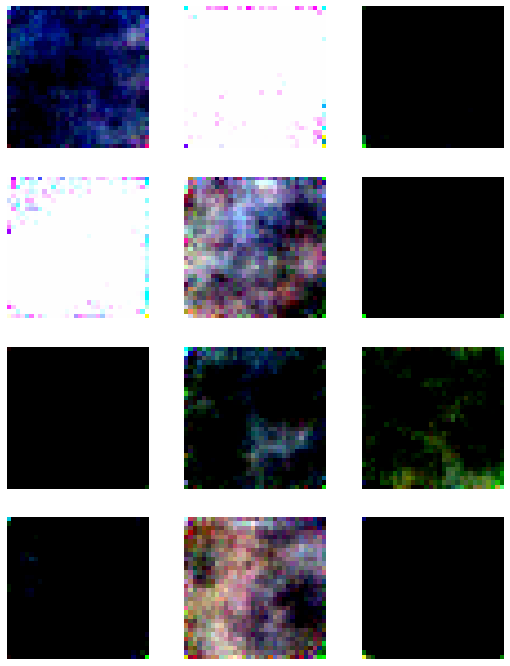

In [22]:
show_images((logit((xs-xs.mean())/xs.std()).sigmoid()),nrows=4)

In [ ]:
xs.min()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

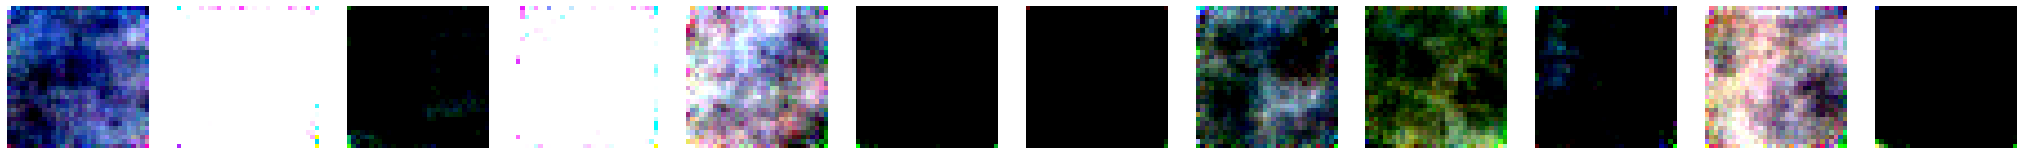

In [21]:
show_images(xs)

In [ ]:
with learn.removed_cbs(WandbCallback):
    show_images(dls.one_batch()[0][:4])

In [ ]:
learn.show_results??

In [ ]:
dls.show_batch(show=False)[2]

In [ ]:
@typedispatch
def wandb_process(x:tuple, y, samples, outs, preds):
    "Process `sample` and `out` depending on the type of `x/y`"
    res_input, res_pred, res_label = [],[],[]
    for s,o in zip(samples, outs):
        img = s[0].permute(1,2,0)
        res_input.append(wandb.Image(img, caption='Input_data'))
        for t, capt, res in ((o[0], "Prediction", res_pred), (s[1], "Ground_Truth", res_label)):
            fig, ax = _make_plt(img)
            # Superimpose label or prediction to input image
            ax = img.show(ctx=ax)
            ax = t.show(ctx=ax)
            res.append(wandb.Image(fig, caption=capt))
            plt.close(fig)
    return {"Inputs":res_input, "Predictions":res_pred, "Ground_Truth":res_label}

In [ ]:
learn.show_results()

In [ ]:
%debug

In [ ]:
#|hide
from nbdev import nbdev_export
nbdev_export()